In [32]:
import complexity as cp
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
#from numba import jit
from itertools import combinations
import tarfile

csv_header = "solution_fitness;trial;fitness;bot_id;sensor_tuples;motor_value".split(";")

In [3]:
def compute_complexity_measure(filename: str, trials: int) -> pd.DataFrame:
    df = pd.read_csv(filename, ";")

    shannon = [compute_shannon_entropy(df, trial) for trial in np.arange(0, trials, 1)]
    mi = [compute_mutual_info(df, trial) for trial in np.arange(0, trials, 1)]

    df.drop(["sensor_tuples", "motor_value", "bot_id"], axis=1, inplace=True)
    output = df.groupby(["trial"]).first()

    output["entropy"] = shannon
    output["mutual_info"] = mi
    
    return output


def compute_shannon_entropy(df: pd.DataFrame, trial: int) -> float:
    trial_x = df[df["trial"] == trial]
    shannon_entropies = trial_x["sensor_tuples"]\
        .apply(lambda values: cp.sensor_tuples_to_string(ast.literal_eval(values)))\
        .apply(lambda values: cp.shannon(values))

    return np.mean(shannon_entropies)
    
from sklearn.metrics import mutual_info_score
## compute the mutual info from dataframe of specific trial
## returns a table with [trial, solution_fitness, fitness, bot_id, mutual_info]
def compute_mutual_info(df: pd.DataFrame, trial: int) -> float:
    trial_x = df[df["trial"] == trial]
    trial_x.reset_index(drop=True, inplace=True)
    pairs = list(combinations(np.arange(0, len(trial_x["bot_id"]), 1), 2))

    mi = []
    for (xi, yi) in pairs:
        x = ast.literal_eval(trial_x.loc[xi]["motor_value"])
        y = ast.literal_eval(trial_x.loc[yi]["motor_value"])
        mi.append(cp.mutual_info(x, y))

    return np.mean(mi)

In [35]:
def extract_tgz(filename: str, basename: str):
    import os.path as path
    target_folder = path.join(path.dirname(filename), "temp")
    tar = tarfile.open(filename, "r:gz")
    tar.extractall(path=target_folder)
    tar.close()
    return path.join(target_folder, basename)

def extract_complexity_measures(basename: str, configurations: int, trials: int):
    index = np.arange(0, configurations, 1)
    
    for i in index:
        best = compute_complexity_measure(f"{basename}_best_{i}.csv", trials)
        middle = compute_complexity_measure(f"{basename}_middle_{i}.csv", trials)
        worst = compute_complexity_measure(f"{basename}_worst_{i}.csv", trials)
        best.to_csv(f"{basename}_best_{i}_complexity.csv", sep=';')
        middle.to_csv(f"{basename}_middle_{i}_complexity.csv", sep=';')
        worst.to_csv(f"{basename}_worst_{i}_complexity.csv", sep=';')

        
def extract_and_update_complexity_measure(from_basename: str, to_basename: str, 
                                          network_type: str, configurations: int, trials: int):
    index = np.arange(0, configurations, 1)
    
    for i in index:
        refreshed = compute_complexity_measure(f"{from_basename}_{network_type}_{i}.csv", trials)
        refreshed.to_csv(f"{to_basename}_{network_type}_{i}_complexity.csv", sep=';')
    
        
def create_table(basename: str, configurations: int):
    index = np.arange(0, configurations, 1)
    
    avg_best = [pd.read_csv(f"{basename}_best_{i}_complexity.csv", ";").mean() for i in index]
    avg_middle = [pd.read_csv(f"{basename}_middle_{i}_complexity.csv", ";").mean() for i in index]
    avg_worst = [pd.read_csv(f"{basename}_worst_{i}_complexity.csv", ";").mean() for i in index]
    
    df = pd.DataFrame()
    
    entropies = [list(map(lambda x: x["entropy"], collection)) for collection in (avg_best, avg_middle, avg_worst)]
    mis = [list(map(lambda x: x["mutual_info"], collection)) for collection in (avg_best, avg_middle, avg_worst)]
    
    sol_fitness = [list(map(lambda x: x["solution_fitness"], collection)) for collection in (avg_best, avg_middle, avg_worst)]
    avg_fitness = [list(map(lambda x: x["fitness"], collection)) for collection in (avg_best, avg_middle, avg_worst)]
    
    df["network"] = [f"{t}_{i}" for t in ["best", "middle", "worst"] for i in index]
    df["entropy_mean"] = np.hstack(entropies)
    df["mutual_info_mean"] = np.hstack(mis)
    df["solution_fitness"] = np.hstack(sol_fitness)
    df["fitness"] = np.hstack(avg_fitness)
    
    return df
        

def create_bar_plot(basename: str, configurations: int, title):
    rcParams["legend.loc"] = "upper right"
    index = np.arange(0, configurations, 1)
    x_labels = np.arange(1, configurations + 1, 1)
    
    avg_best = [pd.read_csv(f"{basename}_best_{i}_complexity.csv", ";").mean() for i in index]
    avg_middle = [pd.read_csv(f"{basename}_middle_{i}_complexity.csv", ";").mean() for i in index]
    avg_worst = [pd.read_csv(f"{basename}_worst_{i}_complexity.csv", ";").mean() for i in index]
    
    
    colors = ['r', 'g', 'b']
    def create_dataframe(best, middle, worst, mapping):
        return pd.DataFrame({ 'migliori' : list(map(mapping, best)), 
                       'discrete' : list(map(mapping, middle)), 
                       'peggiori' : list(map(mapping, worst))}, index=index)
    
    df_entropy = create_dataframe(avg_best, avg_middle, avg_worst, lambda x: x["entropy"])
    df_mi = create_dataframe(avg_best, avg_middle, avg_worst, lambda x: x["mutual_info"])
    
    fig1, ax1 = plt.subplots()
    df_entropy.plot.bar(ax=ax1, rot=0, figsize=(9, 5), width=0.9, color=colors)
    ax1.legend().get_frame().set_alpha(0.3)
    ax1.set_xticklabels(x_labels)
    ax1.set_title(title[0], fontsize=16)
    ax1.set_xlabel("N. rete booleana", fontsize=16)
    ax1.set_ylabel("Entropia", fontsize=16)
    ax1.yaxis.set_tick_params(labelsize=14)
    
    fig2, ax2 = plt.subplots()
    df_mi.plot.bar(ax=ax2, rot=0, figsize=(9, 5), width=0.9, color=colors)
    ax2.legend().get_frame().set_alpha(0.3)
    ax2.set_xticklabels(x_labels)
    ax2.set_title(title[1], fontsize=16)
    ax2.set_xlabel("N. rete booleana", fontsize=16)
    ax2.set_ylabel("Mutua info", fontsize=16)
    ax2.yaxis.set_tick_params(labelsize=14)
    return fig1, fig2

## Task 1

In [4]:
statistics_folder = r'./collected-data/complexity/task1/'
basename = extract_tgz(statistics_folder + 'task1_28-01_22-30.tgz', 'task1')
extract_complexity_measures(basename, 5, 15)

KeyboardInterrupt: 

,network,entropy_mean,mutual_info_mean,solution_fitness,fitness
0,best_0,2.670949,0.239266,0.911111,0.826667
1,best_1,2.696090,0.226630,0.900000,0.793333
2,best_2,2.696090,0.226630,0.900000,0.793333
3,best_3,2.781175,0.239874,0.900000,0.815556
4,best_4,2.261495,0.211685,0.900000,0.793333
5,middle_0,2.331648,0.150890,0.855556,0.711111
6,middle_1,2.743150,0.266121,0.855556,0.795556
7,middle_2,2.630750,0.244637,0.855556,0.804445
8,middle_3,2.504947,0.262390,0.855556,0.806667
9,middle_4,2.737274,0.223209,0.855556,0.797778


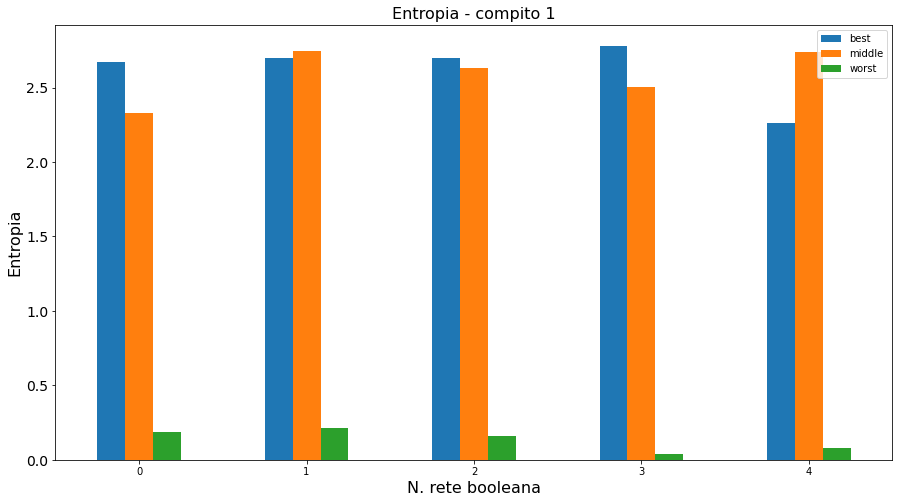

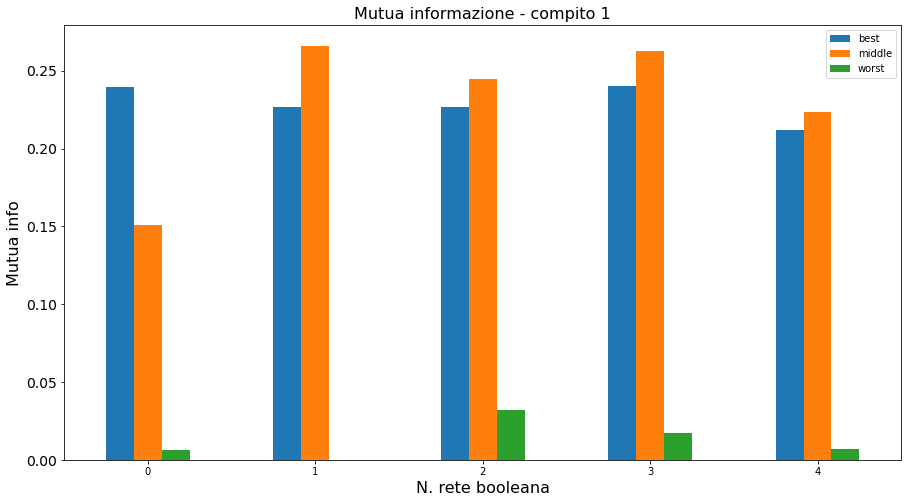

In [6]:
basename = r'./collected-data/complexity/task1/temp/task1'
create_bar_plot(basename, 5, title=("Entropia - compito 1", "Mutua informazione - compito 1"))
display(create_table(basename, 5))

### Bis with 50th generation as middle

In [36]:
statistics_folder = r'./collected-data/complexity/task1/'
basename = extract_tgz(statistics_folder + 'task1_bis_28-01_22-30.tgz', 'task1_bis')
extract_complexity_measures(basename, 5, 15)

,network,entropy_mean,mutual_info_mean,solution_fitness,fitness
0,best_0,2.670949,0.239266,0.911111,0.826667
1,best_1,2.696090,0.226630,0.900000,0.793333
2,best_2,2.696090,0.226630,0.900000,0.793333
3,best_3,2.781175,0.239874,0.900000,0.815556
4,best_4,2.261495,0.211685,0.900000,0.793333
5,middle_0,1.965875,0.085059,0.633333,0.506667
6,middle_1,2.412790,0.042611,0.633333,0.528889
7,middle_2,2.412790,0.042611,0.633333,0.528889
8,middle_3,1.965875,0.085059,0.633333,0.506667
9,middle_4,2.030091,0.081838,0.633333,0.524444


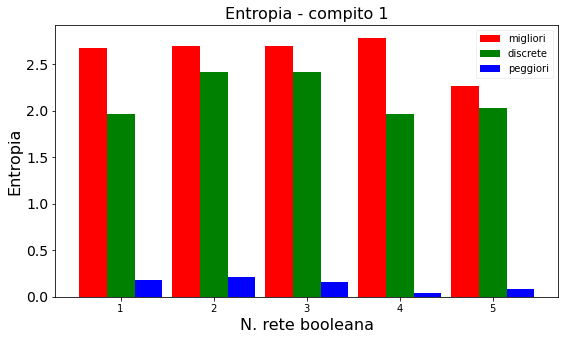

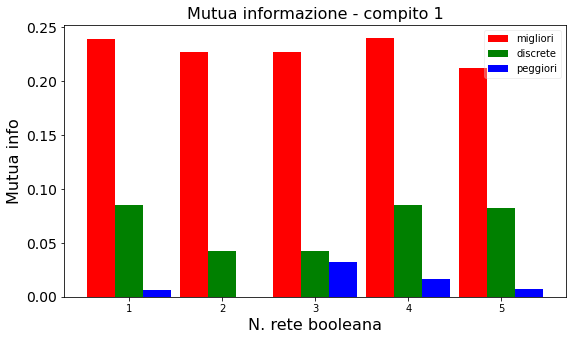

In [36]:
basename = r'./collected-data/complexity/task1/temp/task1_bis'

# extract_and_update_complexity_measure(basename, "middle", 5, 15)

fig1, fig2 = create_bar_plot(basename, 5, title=("Entropia - compito 1", "Mutua informazione - compito 1"))
display(create_table(basename, 5))
fig1.savefig('task1-entropy.pdf')
fig2.savefig('task1-mutual-info.pdf')

## Task 2

In [8]:
statistics_folder = r'./collected-data/complexity/task2/'
basename = extract_tgz(statistics_folder + 'task2_29-01_11-15.tgz', 'task2')
extract_complexity_measures(basename, 5, 15)

,network,entropy_mean,mutual_info_mean,solution_fitness,fitness
0,best_0,1.898096,0.201278,0.900000,0.766667
1,best_1,1.898096,0.201278,0.900000,0.766667
2,best_2,1.887229,0.198115,0.900000,0.744444
3,best_3,1.898096,0.201278,0.900000,0.766667
4,best_4,1.860606,0.190714,0.900000,0.746667
5,middle_0,1.893165,0.198877,0.888889,0.757778
6,middle_1,1.883475,0.195063,0.888889,0.751111
7,middle_2,1.883475,0.195063,0.888889,0.751111
8,middle_3,1.892582,0.200054,0.888889,0.764444
9,middle_4,1.883475,0.195063,0.888889,0.751111


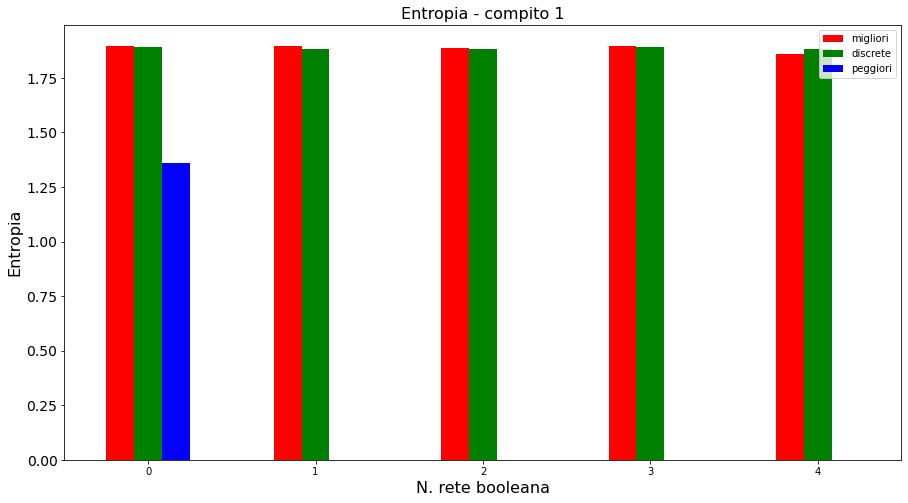

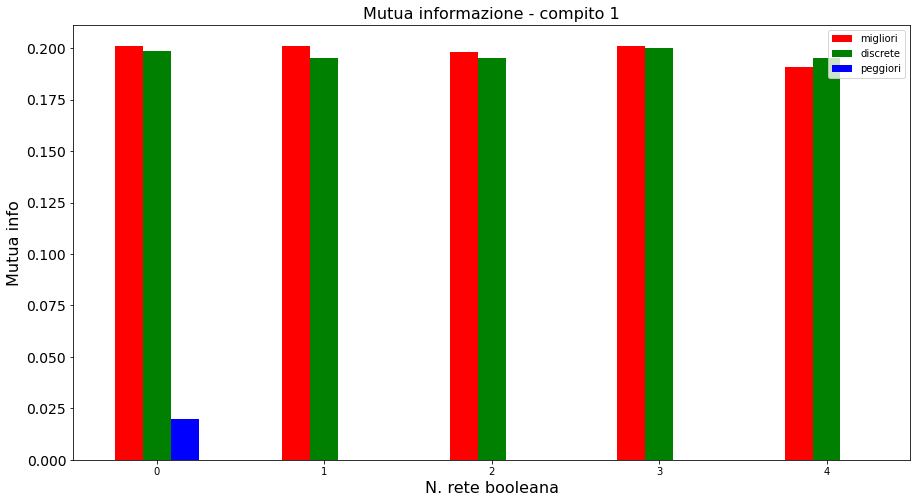

In [16]:
basename = r'./collected-data/complexity/task2/temp/task2'
create_bar_plot(basename, 5, title=("Entropia - compito 1", "Mutua informazione - compito 1"))
display(create_table(basename, 5))

### Bis with 10th generation as worst population

In [37]:
statistics_folder = r'./collected-data/complexity/task2/'
basename = extract_tgz(statistics_folder + 'task2_bis_29-01_11-15.tgz', 'task2_bis')
extract_complexity_measures(basename, 5, 15)

,network,entropy_mean,mutual_info_mean,solution_fitness,fitness
0,best_0,1.898096,0.201278,0.900000,0.766667
1,best_1,1.898096,0.201278,0.900000,0.766667
2,best_2,1.887229,0.198115,0.900000,0.744444
3,best_3,1.898096,0.201278,0.900000,0.766667
4,best_4,1.860606,0.190714,0.900000,0.746667
5,middle_0,2.190043,0.152363,0.711111,0.608889
6,middle_1,1.891657,0.195850,0.711111,0.708889
7,middle_2,2.190260,0.155072,0.711111,0.628889
8,middle_3,2.210050,0.166481,0.711111,0.655556
9,middle_4,2.107382,0.197918,0.711111,0.737778


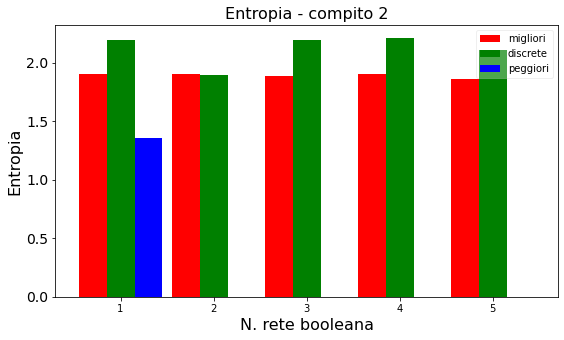

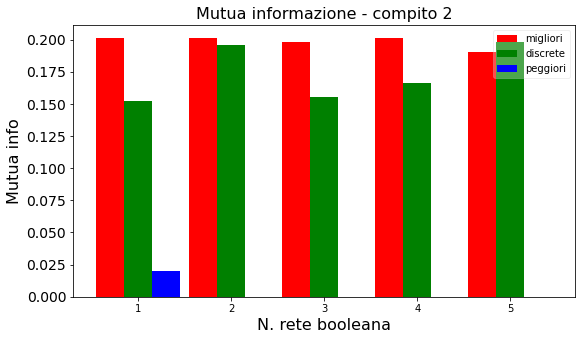

In [37]:
basename = r'./collected-data/complexity/task2/temp/task2_bis'

#extract_and_update_complexity_measure(r'./collected-data/complexity/task2/temp/task2_30',
#                                      basename, "middle", 5, 15)

fig1, fig2 = create_bar_plot(basename, 5, title=("Entropia - compito 2", "Mutua informazione - compito 2"))
display(create_table(basename, 5))
fig1.savefig('task2-entropy.pdf')
fig2.savefig('task2-mutual-info.pdf')

## Task 3

In [10]:
statistics_folder = r'./collected-data/complexity/task3/'
basename = extract_tgz(statistics_folder + 'task3_10-17_23-01.tgz', 'task3')
extract_complexity_measures(basename, 5, 15)

,network,entropy_mean,mutual_info_mean,solution_fitness,fitness
0,best_0,1.611624,0.273927,0.544444,0.395556
1,best_1,1.579665,0.265203,0.533333,0.393333
2,best_2,1.579665,0.265203,0.533333,0.393333
3,best_3,1.567066,0.267773,0.533333,0.391111
4,best_4,1.571323,0.269985,0.533333,0.395556
5,middle_0,1.590373,0.270966,0.511111,0.391111
6,middle_1,1.576022,0.269602,0.511111,0.397778
7,middle_2,1.577946,0.267406,0.511111,0.393333
8,middle_3,1.571504,0.270224,0.511111,0.388889
9,middle_4,1.581396,0.275906,0.511111,0.391111


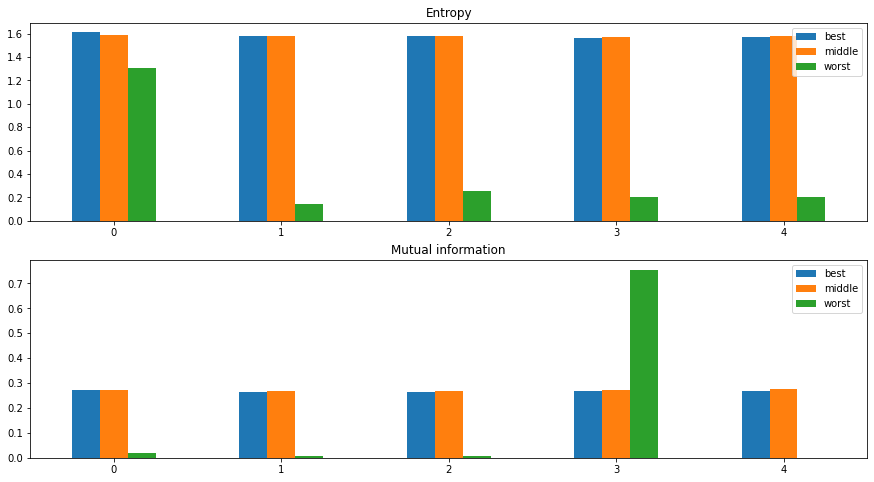

In [22]:
basename = r'./collected-data/complexity/task3/temp/task3'
create_bar_plot(basename, 5)
display(create_table(basename, 5))

In [11]:
statistics_folder = r'./collected-data/complexity/task3/'
#basename = extract_tgz(statistics_folder + 'task3_bis_10-17_23-01.tgz', 'task3_bis')
basename = extract_tgz(statistics_folder + 'task3_30_f_10-17_23-01.tgz', 'task3_30_f')
extract_complexity_measures(basename, 5, 15)

,network,entropy_mean,mutual_info_mean,solution_fitness,fitness
0,best_0,1.611624,0.273927,0.544444,0.395556
1,best_1,1.579665,0.265203,0.533333,0.393333
2,best_2,1.579665,0.265203,0.533333,0.393333
3,best_3,1.567066,0.267773,0.533333,0.391111
4,best_4,1.571323,0.269985,0.533333,0.395556
5,middle_0,1.861307,0.255605,0.400000,0.373333
6,middle_1,1.474102,0.167821,0.400000,0.328889
7,middle_2,1.540828,0.148095,0.400000,0.335556
8,middle_3,1.461880,0.172347,0.400000,0.337778
9,middle_4,1.703940,0.202297,0.400000,0.368889


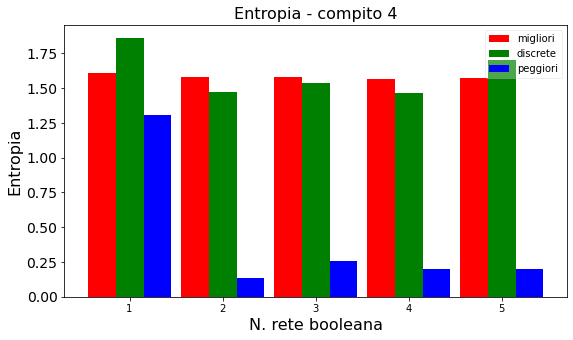

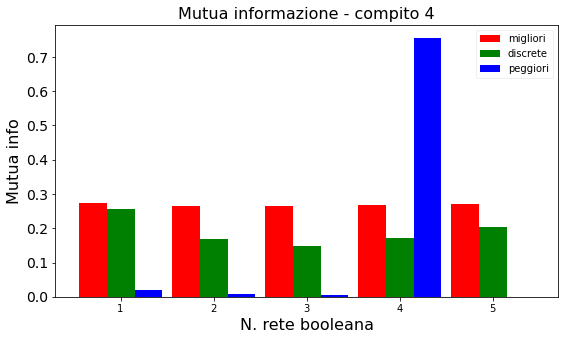

In [38]:
basename = r'./collected-data/complexity/task3/temp/task3_bis'

#xtract_and_update_complexity_measure(r'./collected-data/complexity/task3/temp/task3_30',
#                                      basename, "middle", 5, 15)

fig1, fig2 = create_bar_plot(basename, 5, title=("Entropia - compito 4", "Mutua informazione - compito 4"))
display(create_table(basename, 5))
fig1.savefig('task4-entropy.pdf')
fig2.savefig('task4-mutual-info.pdf')

## Task 4

In [12]:
statistics_folder = r'./collected-data/complexity/task4/'
basename = extract_tgz(statistics_folder + 'task4_18-14_26-01.tgz', 'task4')
extract_complexity_measures(basename, 5, 15)

,network,entropy_mean,mutual_info_mean,solution_fitness,fitness
0,best_0,1.742745,0.101306,0.688889,0.433333
1,best_1,1.742745,0.101306,0.688889,0.433333
2,best_2,1.742745,0.101306,0.688889,0.433333
3,best_3,1.742745,0.101306,0.688889,0.433333
4,best_4,1.742745,0.101306,0.688889,0.433333
5,middle_0,1.749595,0.104017,0.666667,0.437778
6,middle_1,1.766045,0.098780,0.666667,0.444444
7,middle_2,1.724958,0.097523,0.666667,0.420000
8,middle_3,1.765860,0.098800,0.666667,0.444444
9,middle_4,1.749595,0.104017,0.666667,0.437778


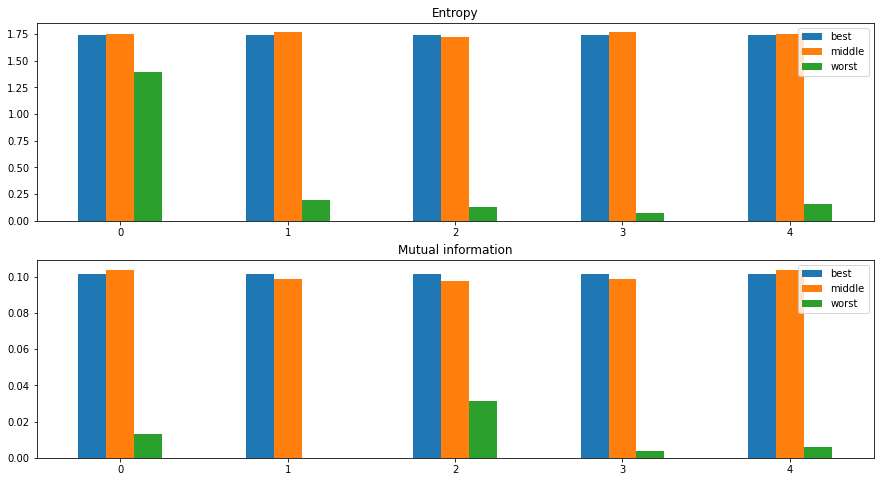

In [21]:
basename = r'./collected-data/complexity/task4/temp/task4'
create_bar_plot(basename, 5)
display(create_table(basename, 5))

In [6]:
statistics_folder = r'./collected-data/complexity/task4/'
basename = extract_tgz(statistics_folder + 'task4_30_cross_26-01_18-14.tgz', 'task4_30_cross')
extract_complexity_measures(basename, 5, 15)

,network,entropy_mean,mutual_info_mean,solution_fitness,fitness
0,best_0,2.697075,0.110883,0.677778,0.537778
1,best_1,2.746230,0.114084,0.655556,0.548889
2,best_2,2.641475,0.116534,0.655556,0.535556
3,best_3,2.746230,0.114084,0.655556,0.548889
4,best_4,2.723638,0.117628,0.644444,0.551111
5,middle_0,1.830279,0.084225,0.466667,0.366667
6,middle_1,1.830279,0.084225,0.466667,0.366667
7,middle_2,1.830279,0.084225,0.466667,0.366667
8,middle_3,1.828923,0.084782,0.466667,0.364444
9,middle_4,1.830483,0.084452,0.466667,0.364444


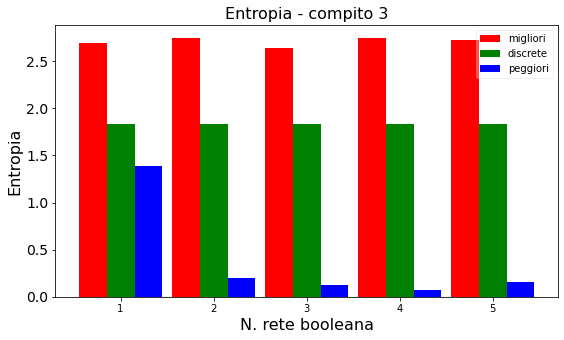

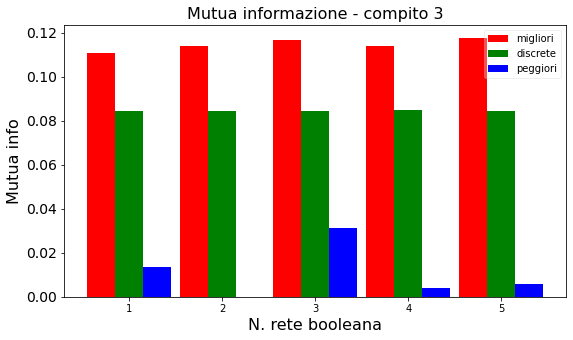

In [39]:
basename = r'./collected-data/complexity/task4/temp/task4_30_cross'
fig1, fig2 = create_bar_plot(basename, 5, title=("Entropia - compito 3", "Mutua informazione - compito 3"))
display(create_table(basename, 5))
fig1.savefig('task3-entropy.pdf')
fig2.savefig('task3-mutual-info.pdf')